## Imports

In [1]:
from sklearn.utils.fixes import loguniform
import numpy as np
import doepy
from doepy import build
import pyDOE2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
from itertools import combinations_with_replacement
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore")
%matplotlib inline

## Functions

In [2]:
np.random.seed(420)
coeffs = np.random.normal(size=6)
def quadratic_function(Pressure, Temperature, coeffs=coeffs):#, Flow_rate
    features = np.array([1, Pressure, Temperature,# Flow_rate, 
                         Pressure**2, Temperature**2,# Flow_rate**2, 
                         Pressure*Temperature]) #, Temperature*Flow_rate, Flow_rate*Pressure])
    return coeffs @ features + np.random.normal(0, 2)

def eval_plan(plan, key="results", **kwargs):
    with tqdm(total=len(plan)) as pbar:
        def to_eval(params): 
            res = quadratic_function(**params, **kwargs)
            pbar.update(1)
            return res
        plan[key] = plan.apply(to_eval, axis=1)
    return plan

In [3]:
print("Quadratic coefficients to evaluate: ", coeffs)

Quadratic coefficients to evaluate:  [-0.48539085 -1.90515385 -0.5262218  -0.31354602  0.33070649  0.93853725]


In [4]:
x_min=-2
x_max=2
y_min=-2
y_max=2
x_prec = 30
y_prec = 30
parameters = {'Pressure':np.linspace(x_min, x_max, x_prec), 
              'Temperature':np.linspace(y_min, y_max, y_prec)}
print("Evaluate function on [{}, {}]x[{}, {}]".format(x_min, x_max, y_min, y_max))

Evaluate function on [-2, 2]x[-2, 2]


In [5]:
def plot_surface(X, Y, values, degree=2, m=500, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, title=""):
    n = len(values)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))
    X = np.array(X)
    Y = np.array(Y)
    target = np.array(values)
    model.fit(np.c_[X, Y], target)
    XX, YY = np.meshgrid(np.linspace(x_min, x_max, m), 
                         np.linspace(y_min, y_max, m))

    Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape((m, m))
    
    if True:     
        fig = plt.figure(figsize=(10, 10))
        plt.title("Response Surface {}".format(title))
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(XX, YY, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.savefig("{}_reponse_surface_3d.png".format("_".join(title.split())))
        plt.close()

    
    fig, ax = plt.subplots(figsize=(10, 10))
    cs = ax.contourf(XX, YY, Z) #, corner_mask=corner_mask
    ax.contour(cs, colors='k')
    fig.colorbar(cs, shrink=0.5, aspect=5)
    ax.scatter(X, Y, c="red")
    ax.set_title('Response Surface {}'.format(title))
    ax.grid(c='k', ls='-', alpha=0.3)
    plt.savefig("{}_reponse_surface.png".format("_".join(title.split())))
    plt.show()
    plt.close()
    return model

In [6]:
def run_plan(plan, title=""):
    design_matrix = plan.copy()
    # Build design and information matrix
    for elt1, elt2 in combinations_with_replacement(design_matrix.columns, 2):
        design_matrix["{}_{}".format(elt1, elt2)] = design_matrix[elt1] * design_matrix[elt2]
    design_matrix["intercept"] = 1
    information_matrix = design_matrix.values.T @ design_matrix.values
    det = np.linalg.det(information_matrix)
    print("Determinant of X.T @ X: ", det)
    
    try:
        inv = np.linalg.inv(information_matrix)
        inv_det = np.linalg.det(inv)
    except:
        pass

    if False:
        plan.plot.scatter(x=plan.columns[0],
                          y=plan.columns[1],
                          c='DarkBlue')
        plt.title("Points in plan")
        plt.show()
        plt.close()

    results = eval_plan(plan)  # Evaluate values of functions for each value in the plan
    
    if False:  # Matrice show
        enc = OrdinalEncoder()
        enc.fit(results.loc[:, results.columns != 'results'])
        indices = enc.transform(results.loc[:, results.columns != 'results'])
        shape = tuple([len(elt) for elt in enc.categories_])
        values = np.zeros(shape)
        for idx, value in zip(indices, results['results']):
            idx = tuple(map(int, idx))
            values[idx] = value

        plt.matshow(values[:,:])
        plt.show()
        plt.close()
    
    plot_surface(  # Plot and save response surface
        results["Temperature"], results["Pressure"], results["results"], 
        title=title
    )

# Full plan
Full factorial design.

In [7]:
help(build.full_fact)

Help on function full_fact in module doepy.build:

full_fact(d)
    Builds a full factorial design dataframe from a dictionary of factor/level ranges
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,60,70],'Temperature':[290, 320, 350],'Flow rate':[0.9,1.0]}



Determinant of X.T @ X:  5.753751708122107e+18


100%|██████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 12162.22it/s]


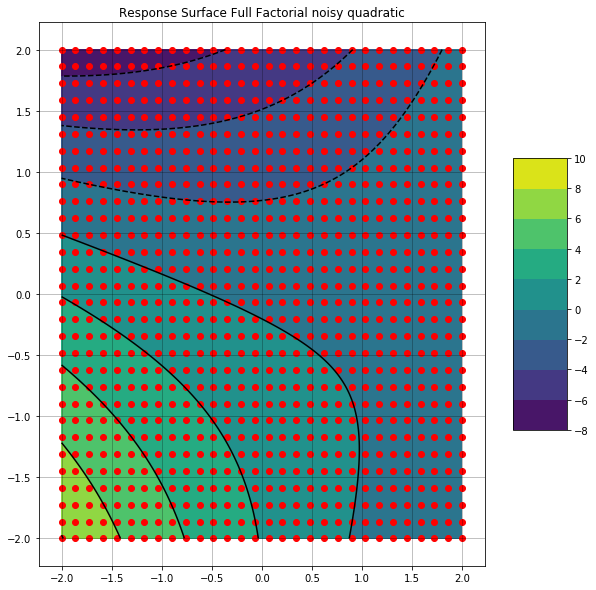

In [8]:
try:
    plan = build.full_fact(
        deepcopy(parameters)
    )
    run_plan(plan, "Full Factorial noisy quadratic")
except Exception as e:
    print(e)

# 2-level fractorial design

In [9]:
help(build.frac_fact_res)

Help on function frac_fact_res in module doepy.build:

frac_fact_res(d, res=None)
    Builds a 2-level fractional factorial design dataframe from a dictionary of factor/level ranges and given resolution.
      
    Parameters
    ----------
    factor_level_ranges : Dictionary of factors and ranges
                         Only min and max values of the range are required.
                         If more than two levels are given, the extreme values will be set to the low/high levels.
                         Example of the dictionary which is needed as the input:
                        {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    res : int
        Desired design resolution.
        Default: Set to half of the total factor count.
        
        Notes
    -----
    The resolution of a design is defined as the length of the shortest
    word in the defining relation. The resolution describes the level of
    confounding between factors and interaction effec

In [10]:
# Not enough parameters
try:
    plan = build.frac_fact_res(
        deepcopy(parameters)
    )
    run_plan(plan, "2-level fractional factorial design noisy quadratic")
except Exception as e:
    print(e)

Number of factors must be greater than desired resolution


# Box Behnken

In [11]:
help(build.box_behnken)  # Levels but only numerics

Help on function box_behnken in module doepy.build:

box_behnken(d, center=1)
    Builds a Box-Behnken design dataframe from a dictionary of factor/level ranges.
    Note 3 levels of factors are necessary. If not given, the function will automatically create 3 levels by linear mid-section method.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,60,70],'Temperature':[290, 320, 350],'Flow rate':[0.9,1.0,1.1]}
        
        In statistics, Box–Behnken designs are experimental designs for response surface methodology, devised by George E. P. Box and Donald Behnken in 1960, to achieve the following goals:
                * Each factor, or independent variable, is placed at one of three equally spaced values, usually coded as −1, 0, +1. (At least three levels are needed for the following goal.)
                * The design should be sufficient to fit a quadratic model, that is, one containing squared terms, products of two factors, linear terms and an interce

In [12]:
# Needs at least 3 parameters
try:
    plan = build.box_behnken(
        deepcopy(parameters)
    )
    run_plan(plan, "Box-Behnken design noisy quadratic")
except Exception as e:
    print(e)

Number of variables must be at least 3


# Plackett-Burman

In [13]:
help(build.plackett_burman)  # Only numerical/range values

Help on function plackett_burman in module doepy.build:

plackett_burman(d)
    Builds a Plackett-Burman dataframe from a dictionary of factor/level ranges.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
        
        Plackett–Burman designs are experimental designs presented in 1946 by Robin L. Plackett and J. P. Burman while working in the British Ministry of Supply.(Their goal was to find experimental designs for investigating the dependence of some measured quantity on a number of independent variables (factors), each taking L levels, in such a way as to minimize the variance of the estimates of these dependencies using a limited number of experiments. 
        
    Interactions between the factors were considered negligible. The solution to this problem is to find an experimental design where each combination of levels for any pair of facto

Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
Determinant of X.T @ X:  0.0


100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1333.43it/s]


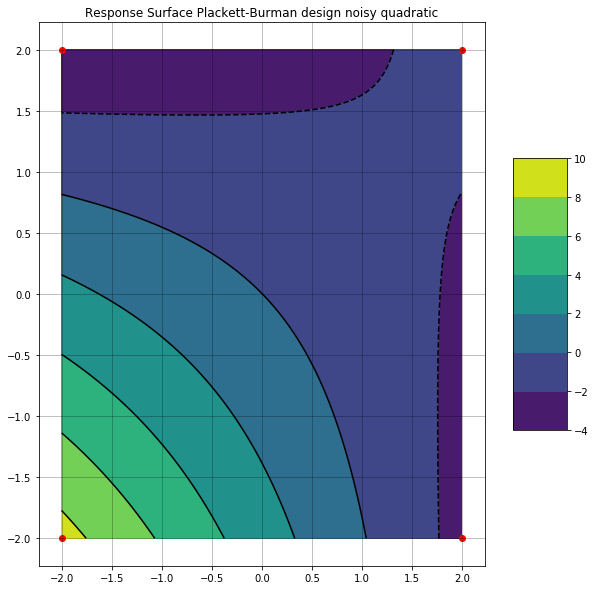

In [14]:
try:
    plan = build.plackett_burman(
        deepcopy(parameters)
    )
    run_plan(plan, "Plackett-Burman design noisy quadratic")
except Exception as e:
    print(e)

# Sukharev

In [15]:
help(build.sukharev)  # Only numerical/range values

Help on function sukharev in module doepy.build:

sukharev(d, num_samples=None)
    Builds a Sukharev-grid hypercube design dataframe from a dictionary of factor/level ranges.
    Number of samples raised to the power of (1/dimension), where dimension is the number of variables, must be an integer.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated
        
        Special property of this grid is that points are not placed on the boundaries of the hypercube, but at centroids of the  subcells constituted by individual samples. 
        This design offers optimal results for the covering radius regarding distances based on the max-norm.



Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.

Number of samples not adequate to fill a Sukharev grid. Increasing sample size to:  16
Determinant of X.T @ X:  40959999.99999993


100%|█████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 4003.63it/s]


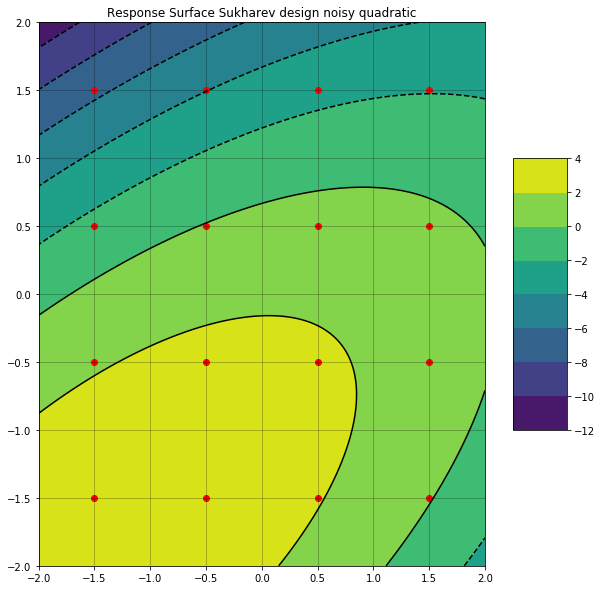

In [16]:
try:
    plan = build.sukharev(
        deepcopy(parameters), num_samples=12
    )
    run_plan(plan, "Sukharev design noisy quadratic")
except Exception as e:
    print(e)

# Central Composite

In [17]:
help(build.central_composite)  #  Only numerical/range values

Help on function central_composite in module doepy.build:

central_composite(d, center=(2, 2), alpha='o', face='ccc')
    Builds a central-composite design dataframe from a dictionary of factor/level ranges.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
        
        In statistics, a central composite design is an experimental design, useful in response surface methodology, for building a second order (quadratic) model for the response variable without needing to use a complete three-level factorial experiment.
        The design consists of three distinct sets of experimental runs:
                * A factorial (perhaps fractional) design in the factors studied, each having two levels;
                * A set of center points, experimental runs whose values of each factor are the medians of the values used in the factorial portion. This point 

In [18]:
faces = {'ccf', 'cci', 'ccc'}
for face in faces:
    try:
        print(face)
        plan = build.central_composite(
            deepcopy(parameters), face=face
        )
        run_plan(plan, "Central composite design {} noisy quadratic".format(face))
    except Exception as e:
        print(e)

ccc
Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
'numpy.ndarray' object has no attribute 'append'
ccf
Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
'numpy.ndarray' object has no attribute 'append'
cci
Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
'numpy.ndarray' object has no attribute 'append'


# Latin hypercube sampling

In [19]:
help(build.lhs)  # Only numerical/range values

Help on function lhs in module doepy.build:

lhs(d, num_samples=None, prob_distribution=None)
    Builds a Latin Hypercube design dataframe from a dictionary of factor/level ranges.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated
    prob_distribution: Analytical probability distribution to be applied over the randomized sampling. 
        Accepts one of the following strings: 
    'Normal', 'Poisson', 'Exponential', 'Beta', 'Gamma'
    
        Latin hypercube sampling (LHS) is a form of stratified sampling that can be applied to multiple variables. The method commonly used to reduce the number or runs necessary for a Monte Carlo simulation to achieve a reasonably accurate random distribution. LHS can be incorporated into an existing Monte Carlo model fairly easily, and work with variables followin

Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
Determinant of X.T @ X:  21373192.359183643


100%|█████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2398.46it/s]


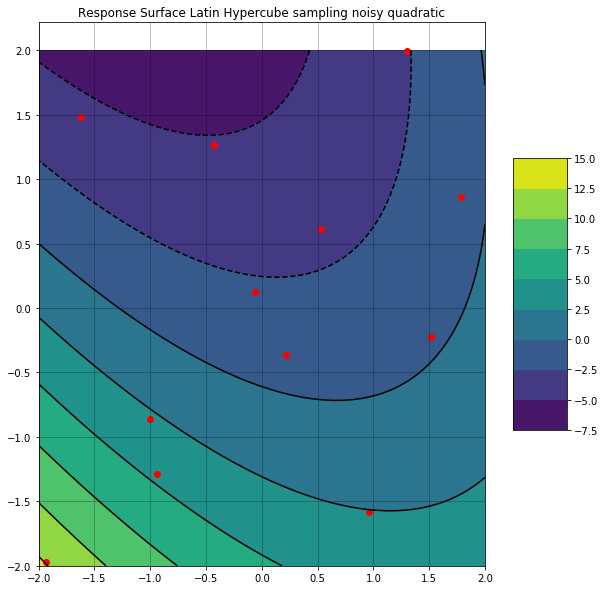

In [20]:
try:
    plan = build.lhs(
        deepcopy(parameters), num_samples=12
    )
    run_plan(plan, "Latin Hypercube sampling noisy quadratic")
except Exception as e:
    print(e)

# Space filling Latin Hypercube sampling

In [21]:
help(build.space_filling_lhs)  #  Only numerical/range

Help on function space_filling_lhs in module doepy.build:

space_filling_lhs(d, num_samples=None)
    Builds a space-filling Latin Hypercube design dataframe from a dictionary of factor/level ranges.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated



Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
Determinant of X.T @ X:  27397022.936563846


100%|█████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 3999.97it/s]


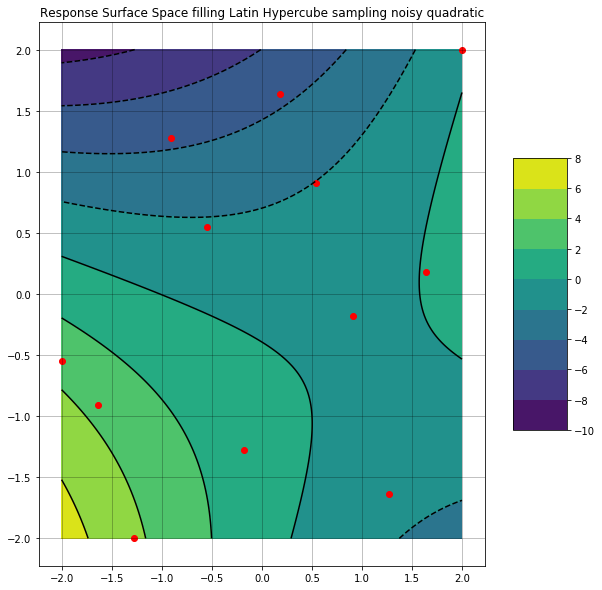

In [22]:
try:
    plan = build.space_filling_lhs(
        deepcopy(parameters), num_samples=12
    )
    run_plan(plan, "Space filling Latin Hypercube sampling noisy quadratic")
except Exception as e:
    print(e)

# Random k-means

In [23]:
help(build.random_k_means)  #  Only numerical/range values

Help on function random_k_means in module doepy.build:

random_k_means(d, num_samples=None)
    This function aims to produce a centroidal Voronoi tesselation of the unit random hypercube and generate k-means clusters.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated



Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
Determinant of X.T @ X:  4654310.685256338


100%|█████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 6000.43it/s]


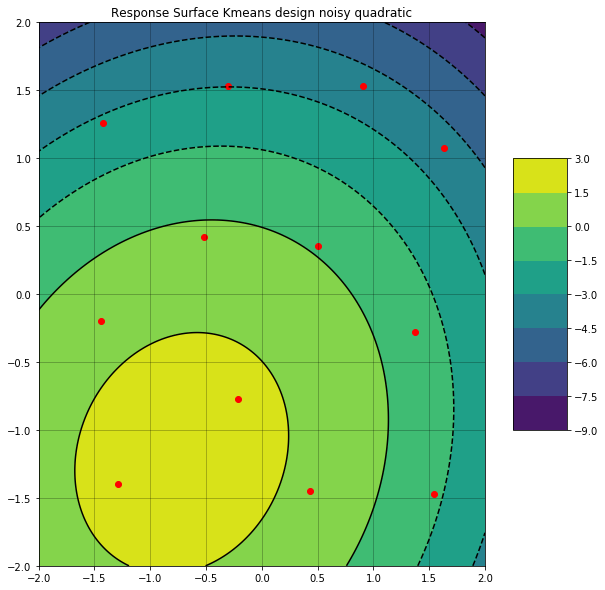

In [24]:
try:
    plan = build.random_k_means(
        deepcopy(parameters), num_samples=12
    )
    run_plan(plan, "Kmeans design noisy quadratic")
except Exception as e:
    print(e)

# Maximin

In [25]:
help(build.maximin)  #  Only numerical/range values

Help on function maximin in module doepy.build:

maximin(d, num_samples=None)
    Builds a maximin reconstructed design dataframe from a dictionary of factor/level ranges.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated
        
        This algorithm carries out a user-specified number of iterations to maximize the minimal distance of a point in the set to 
                * other points in the set, 
                * existing (fixed) points, 
                * the boundary of the hypercube.



Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
Determinant of X.T @ X:  10791839.65295741


100%|█████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 4005.70it/s]


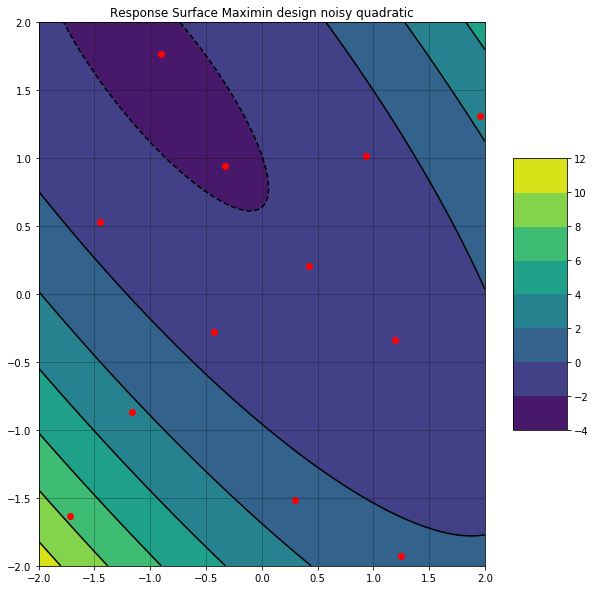

In [26]:
try:
    plan = build.maximin(
        deepcopy(parameters), num_samples=12
    )
    run_plan(plan, "Maximin design noisy quadratic")
except Exception as e:
    print(e)

# Halton

In [27]:
help(build.halton)  #  Only numerical/range values

Help on function halton in module doepy.build:

halton(d, num_samples=None)
    Builds a quasirandom dataframe from a dictionary of factor/level ranges using prime numbers as seed.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated
    
    Quasirandom sequence using the default initialization with first n prime numbers equal to the number of factors/variables.



Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
Determinant of X.T @ X:  10000474.923117092


100%|█████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 6006.16it/s]


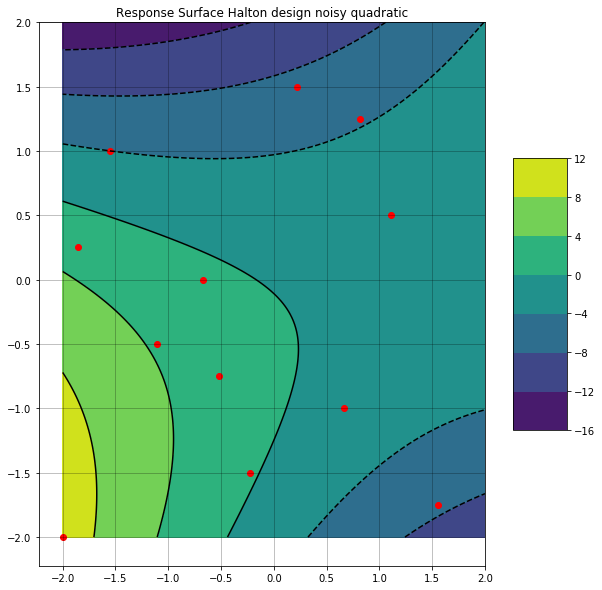

In [28]:
try:
    plan = build.halton(
        deepcopy(parameters), num_samples=12
    )
    run_plan(plan, "Halton design noisy quadratic")
except Exception as e:
    print(e)

# Uniform Random

In [29]:
help(build.uniform_random)  # Only numerical/range values

Help on function uniform_random in module doepy.build:

uniform_random(d, num_samples=None)
    Builds a design dataframe with samples drawn from uniform random distribution based on a dictionary of factor/level ranges.
    Only min and max values of the range are required.
    Example of the dictionary which is needed as the input:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated



Pressure had more than two levels. Assigning the end point to the high level.
Temperature had more than two levels. Assigning the end point to the high level.
Determinant of X.T @ X:  13053569.268928163


100%|█████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2998.79it/s]


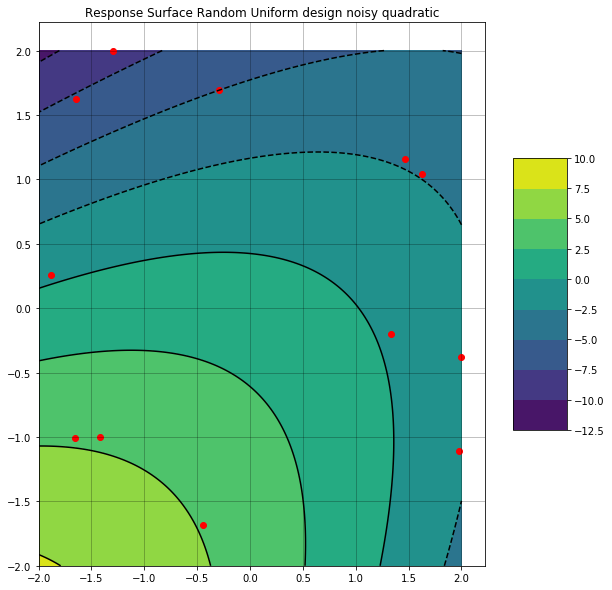

In [30]:
try:
    plan = build.uniform_random(
        deepcopy(parameters), num_samples=12
    )
    run_plan(plan, "Random Uniform design noisy quadratic")
except Exception as e:
    print(e)